In [184]:
%load_ext autoreload

%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [185]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import cv2
import warnings
warnings.filterwarnings("ignore")
from mpl_toolkits.axes_grid1 import ImageGrid
from PIL import Image

from tools import load_json, print_div, export_annos, final_join, filter_by_csv, assign_viewpoints
from plot_images import plot_images
from config import config


### Load data

In [186]:
species = "leopard"
config = config(species)

train_anno_path = config["train_anno_path"]
val_anno_path = config["val_anno_path"]
test_anno_path = config["test_anno_path"]

train_images_dir = config["train_images_dir"]

excluded_viewpoints = config['excluded_viewpoints']

train_data = load_json(train_anno_path)
val_data = load_json(val_anno_path)
test_data = load_json(test_anno_path)


dfa_train = pd.DataFrame(train_data['annotations'])
dfi_train = pd.DataFrame(train_data['images'])

dfa_val = pd.DataFrame(val_data['annotations'])
dfi_val = pd.DataFrame(val_data['images'])

dfa_test = pd.DataFrame(test_data['annotations'])
dfi_test = pd.DataFrame(test_data['images'])


dfa = pd.concat([dfa_train, dfa_val, dfa_test])
dfi = pd.concat([dfi_train, dfi_val, dfi_test])

dfa = assign_viewpoints(dfa, excluded_viewpoints)


df = dfa.merge(dfi, left_on='image_id', right_on='id')
df = df.reset_index(drop=True)


df['path'] = df['file_name'].apply(lambda x: os.path.join(train_images_dir, x))

assert df['path'].apply(os.path.exists).all()

In [187]:
# Need to create 'species' key in the df. Automatically build this from coco file categories

cat_list = test_data['categories']
cat_map = {item['id']: item['name'] for item in cat_list}
df['species'] = df['category_id'].map(cat_map)

cat_map

{0: 'leopard'}

10931


<AxesSubplot:>

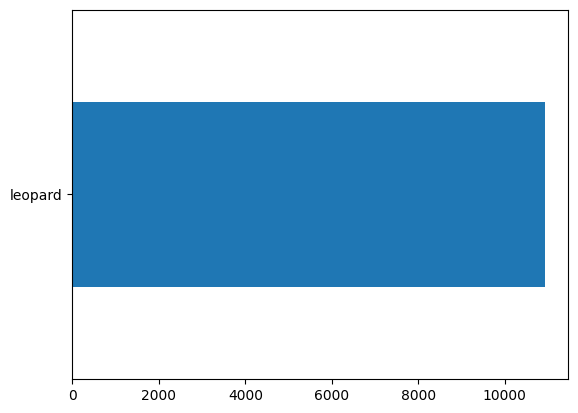

In [188]:
print(len(df))
df['species'].value_counts().plot(kind='barh')

In [189]:
# Filter by csv. Support multiple files

csv_folder = config['csv_folder']

df = filter_by_csv(df, csv_folder)


7012


<AxesSubplot:>

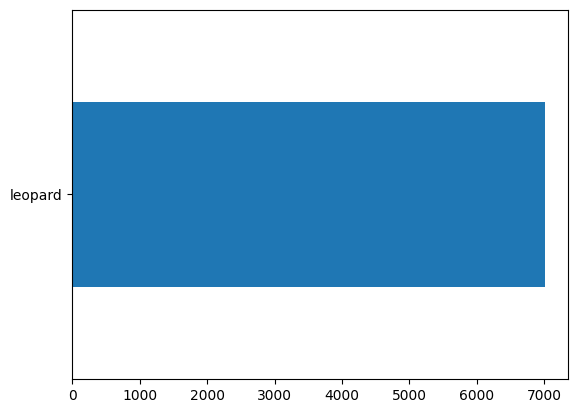

In [190]:
print(len(df))
df['species'].value_counts().plot(kind='barh')

In [191]:
df['name_viewpoint'] = df['name'] + '-' + df['viewpoint']
df['species_viewpoint'] = df['species'] + '-' + df['viewpoint']

In [192]:
# Make sure merging did not create duplicates
assert not df.astype(str).duplicated().any()

### Visualize

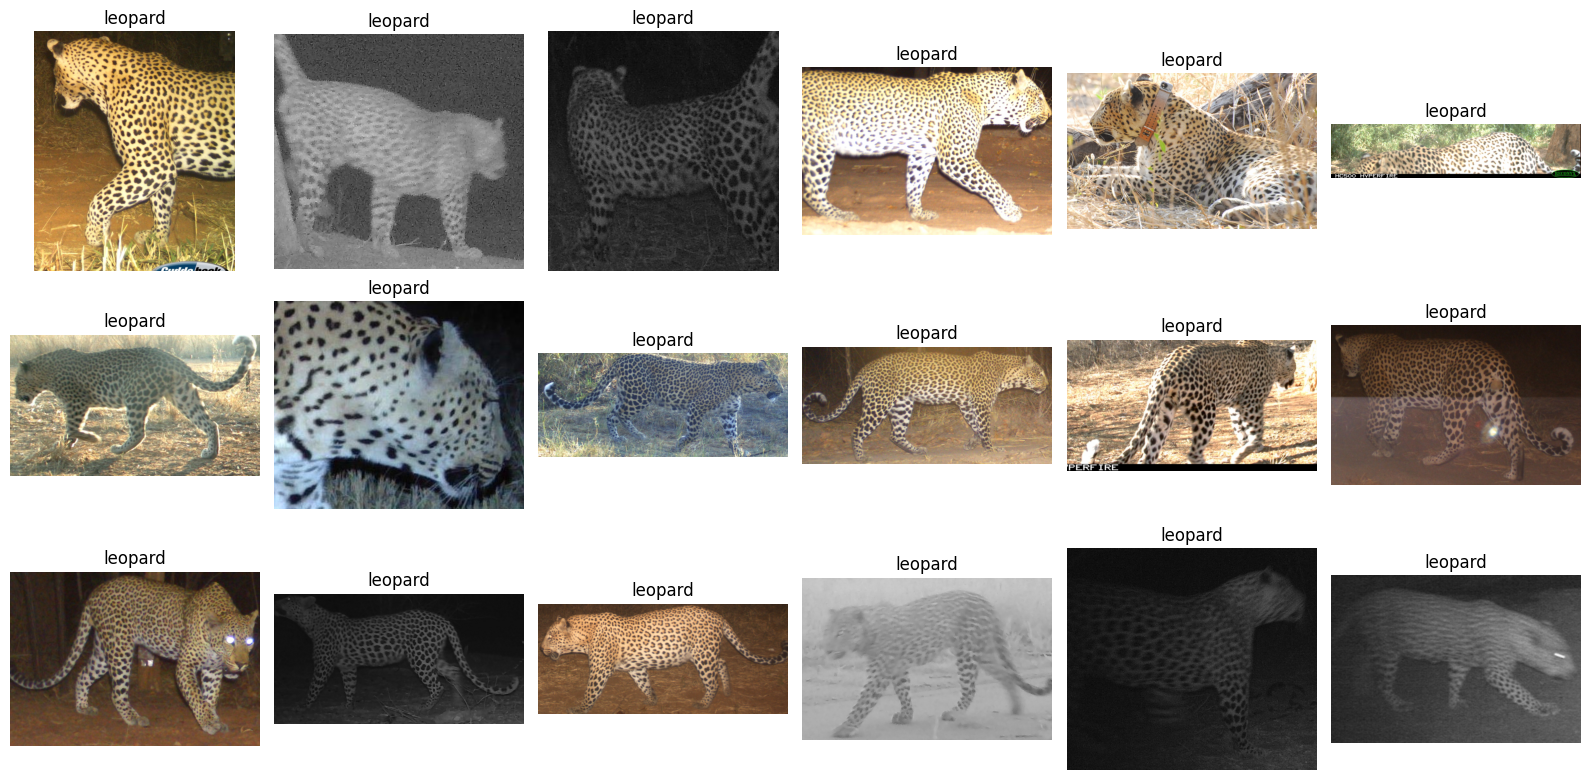

In [193]:
for species in df['species'].unique():
    plot_images(df, species=species, crop_bbox=True)

### Split
- The split 

In [194]:
from split import split_df

In [195]:
df['species'].value_counts()

leopard    7012
Name: species, dtype: int64

Applying filter_min=True
Calculating stats for existing combined subsets
** cross-set stats **

- Counts: 
number of individuals in train:  706
number of annotations in train:  5343

number of individuals in test:  133
number of annotations in test:  608

average number of annotations per individual in train: 7.57
average number of annotations per individual in test: 4.57

- New individuals: 
number of new (unseen) individuals in test: 48
ratio of new names to all individuals in test: 0.36

- Individuals in both sets: 
number of overlapping individuals in train & test: 85
ratio of overlapping names to total individuals in train: 0.12
ratio of overlapping names to total individuals in test: 0.64
** cross-set stats **

- Counts: 
number of individuals in train:  706
number of annotations in train:  5343

number of individuals in val:  151
number of annotations in val:  830

average number of annotations per individual in train: 7.57
average number of annotations per individual in val: 5.

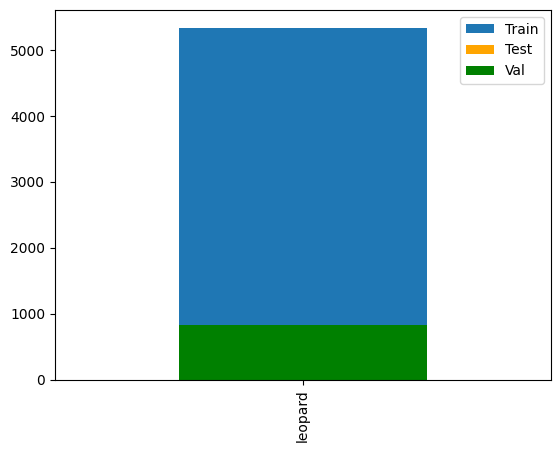

In [196]:
### Split second part separately

df_tr, df_val, df_te = split_df(df, sgkf_n_splits=8, skf_n_splits=8, random_state=0, filter_min_max=True)


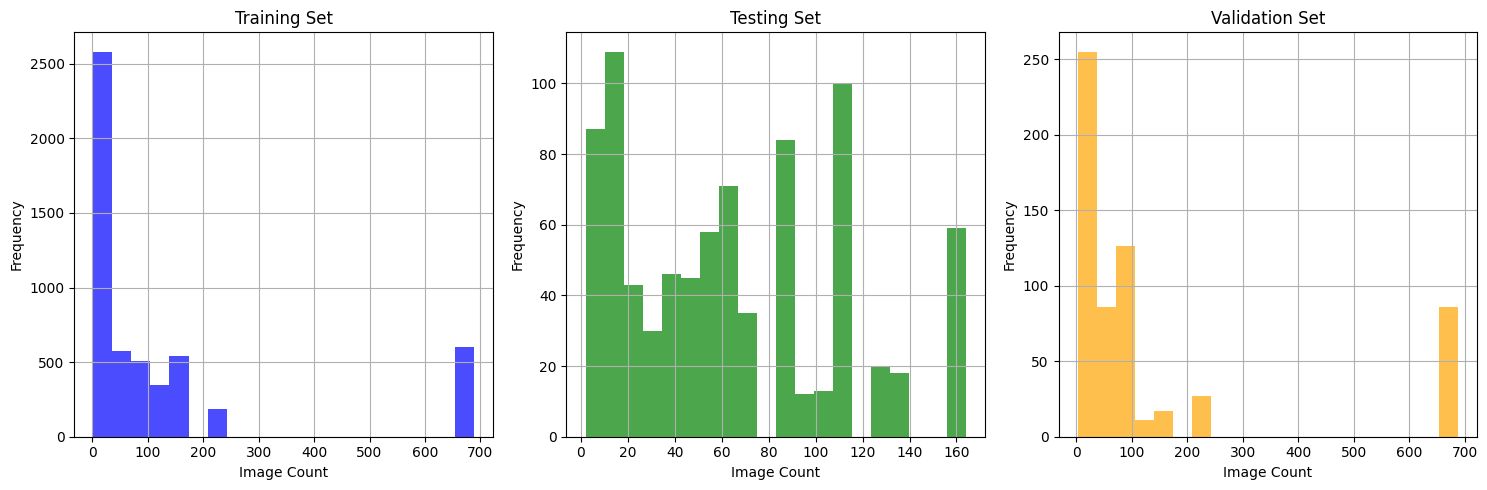

In [197]:

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot histograms for each DataFrame in a separate subplot
df_tr['image_count'].hist(ax=axes[0], bins=20, color='blue', alpha=0.7)
axes[0].set_title('Training Set')
axes[0].set_xlabel('Image Count')
axes[0].set_ylabel('Frequency')

df_te['image_count'].hist(ax=axes[1], bins=20, color='green', alpha=0.7)
axes[1].set_title('Testing Set')
axes[1].set_xlabel('Image Count')
axes[1].set_ylabel('Frequency')

df_val['image_count'].hist(ax=axes[2], bins=20, color='orange', alpha=0.7)
axes[2].set_title('Validation Set')
axes[2].set_xlabel('Image Count')
axes[2].set_ylabel('Frequency')

# Adjust layout
plt.tight_layout()
plt.show()

### Generate files to be exported






In [198]:
dfa_tr, dfi_tr = final_join(df_tr, dfa, dfi, df)
dfa_te, dfi_te = final_join(df_te, dfa, dfi, df)
dfa_val, dfi_val = final_join(df_val, dfa, dfi, df)


### Final data distribution sanity checks

<AxesSubplot:>

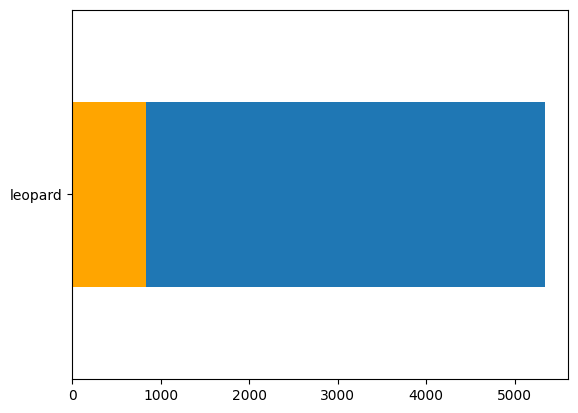

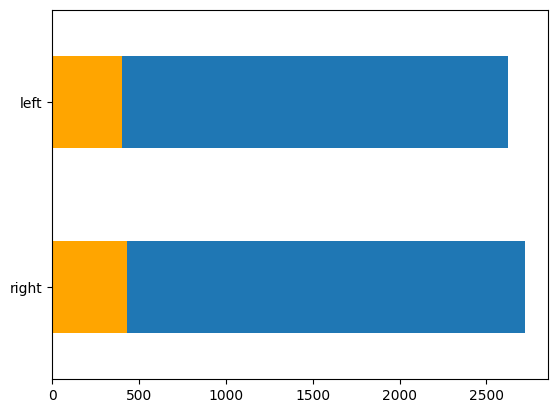

In [199]:
fig, ax = plt.subplots()
# ax2 = ax.twiny()
dfa_tr['species'].value_counts().plot(kind='barh', ax=ax)
dfa_te['species'].value_counts().plot(kind='barh', ax=ax, color='orange')

fig, ax = plt.subplots()
# ax2 = ax.twiny()
dfa_tr['viewpoint'].value_counts().plot(kind='barh', ax=ax)
dfa_te['viewpoint'].value_counts().plot(kind='barh', ax=ax, color='orange')


In [200]:
assert not dfa_tr['uuid'].duplicated().any()

### Export

In [201]:
export_dir = config["export_dir"]
os.makedirs(export_dir, exist_ok=True)

coco_path = lambda split: f"instances_{split}2023.json"

train_coco_path = os.path.join(export_dir, coco_path('train'))
val_coco_path = os.path.join(export_dir, coco_path('val'))
test_coco_path = os.path.join(export_dir, coco_path('test'))

export_annos(dfa_tr, dfi_tr, train_coco_path)
export_annos(dfa_val, dfi_val, val_coco_path)
export_annos(dfa_te, dfi_te, test_coco_path)

out_path /media/kate/Elements1/ISYNC-LUT/leopard/coco/vp_annotations/instances_train2023.json
shapes:  (5343, 20) (5335, 12)
len(images_list) 5335
len(annos_list) 5343
out_path /media/kate/Elements1/ISYNC-LUT/leopard/coco/vp_annotations/instances_val2023.json
shapes:  (608, 20) (608, 12)
len(images_list) 608
len(annos_list) 608
out_path /media/kate/Elements1/ISYNC-LUT/leopard/coco/vp_annotations/instances_test2023.json
shapes:  (830, 20) (830, 12)
len(images_list) 830
len(annos_list) 830
